In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")



**Data wrangling**


In [9]:
df =  (
       pd.read_csv('./data/sp500.csv', parse_dates=["DATE"])
       .set_index("DATE")
       )
df.shape


(1305, 1)

In [10]:
df.head()

,SP500
DATE,
2018-10-08,2884.43
2018-10-09,2880.34
2018-10-10,2785.68
2018-10-11,2728.37
2018-10-12,2767.13


In [11]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1305 entries, 2018-10-08 to 2023-10-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SP500   1305 non-null   object
dtypes: object(1)
memory usage: 20.4+ KB


In [12]:
df['SP500']= pd.to_numeric(df['SP500'], errors='coerce')
df = pd.DataFrame(df)
df = df.dropna()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2018-10-08 to 2023-10-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   1258 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


In [14]:
ad_fuller_result = adfuller(df)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.448717222058159
p-value: 0.5587107039928977


In [15]:
eps_diff = np.diff(df['SP500'], n=1)
ad_fuller_result = adfuller(eps_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -10.927392046359765
p-value: 1.0021416866508158e-19


In [16]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
d = 1

order_list = list(product(ps, qs))


In [18]:
limit = np.int(0.2*len(df))
train = df.iloc[:-limit]
test = df.iloc[-limit:]

result_df = optimize_ARIMA(train, order_list, d)
result_df.head()


  0%|          | 0/25 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(4, 4)",10543.153891
1,"(2, 2)",10546.233553
2,"(3, 2)",10546.889565
3,"(2, 4)",10548.285411
4,"(4, 2)",10548.608351


In [19]:
order = result_df.iloc[0,0]
order

(4, 4)

In [20]:
model = SARIMAX(train, order=(order[0],d,order[1]), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  SP500   No. Observations:                 1007
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -5262.577
Date:                Sat, 14 Oct 2023   AIC                          10543.154
Time:                        09:21:12   BIC                          10587.378
Sample:                             0   HQIC                         10559.957
                               - 1007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2464      0.035     -6.969      0.000      -0.316      -0.177
ar.L2          0.7804      0.034     23.089      0.000       0.714       0.847
ar.L3         -0.3807      0.030    -12.678      0.0

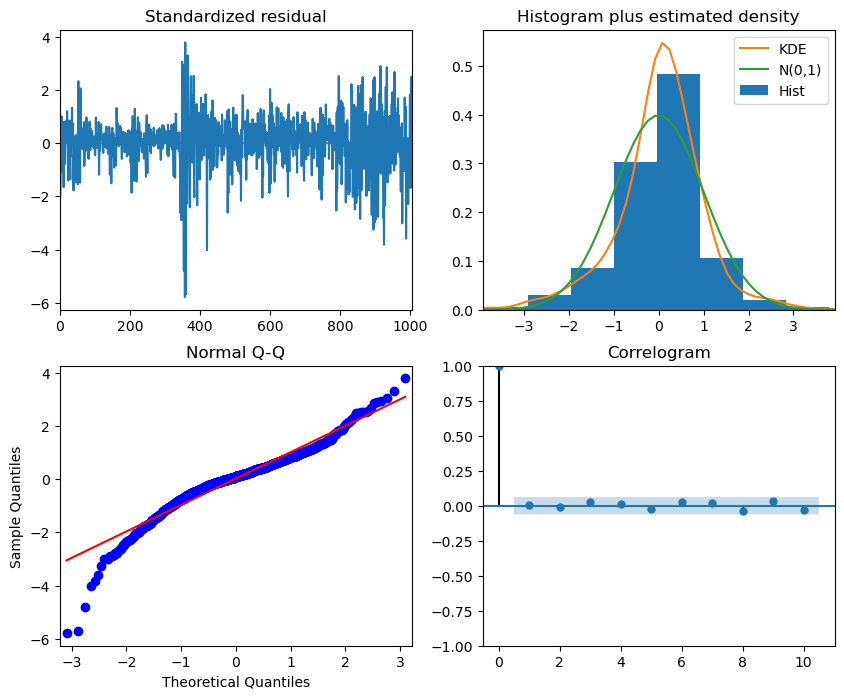

In [21]:
model_fit.plot_diagnostics(figsize=(10,8));
plt.savefig('./data/sp_500.png', dpi=300)


In [22]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

[0.9927132  0.66988599 0.80044621 0.87923691 0.94045484 0.9551491
 0.97841679 0.97884469 0.98977133 0.99509589]


In [23]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, d: int) -> list:
    
    total_len = train_len + horizon
    
    
    pred_ARMA = []
    
    for i in range(train_len, total_len, window):
        model = SARIMAX(endog=df, order=(order[0],d,order[1]))
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, i + window - 1)
        oos_pred = predictions.predicted_mean.iloc[-window:]
        pred_ARMA.extend(oos_pred)
        
    return pred_ARMA




In [24]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1
pred_ARMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW,d)
    

In [25]:
df_test  = pd.DataFrame(test)
df_test["pred_fort"] = pred_ARMA
df_test.head()

,SP500,pred_fort
DATE,,
2022-10-07,3639.66,3736.982724
2022-10-10,3612.39,3630.969524
2022-10-11,3588.84,3606.481073
2022-10-12,3577.03,3588.662524
2022-10-13,3669.91,3593.261756


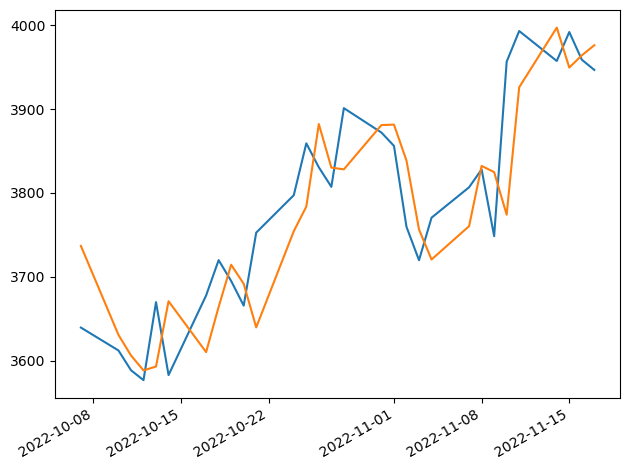

In [26]:
fig, ax = plt.subplots()
ax.plot(df_test['SP500'].iloc[:30], label='Actual')
ax.plot(df_test["pred_fort"].iloc[:30], label='Actual')
fig.autofmt_xdate()
plt.tight_layout()

In [27]:
df_test

,SP500,pred_fort
DATE,,
2022-10-07,3639.66,3736.982724
2022-10-10,3612.39,3630.969524
2022-10-11,3588.84,3606.481073
2022-10-12,3577.03,3588.662524
2022-10-13,3669.91,3593.261756
...,...,...
2023-10-02,4288.39,4287.845187
2023-10-03,4229.45,4281.305054
2023-10-04,4263.75,4234.018391
